# 17. 트랜스포머(Transformer)

이번 트랜스포머 챕터에서는 seq2seq의 단점을 개선하면서도 여전히 인코더-디코더 구조를 유지하고 있는 트랜스포머 모델을 통해 챗봇을 구현해보도록 하겠다.


## 1) 트랜스포머(Transformer)

* 이번 챕터는 앞서 설명한 어텐션 메커니즘 챕터에 대한 사전 이해가 필요하다.

트랜스포머(Transformer)는 2017년 구글이 발표한 논문인 "Attention is all you need"에서 따온 모델로 기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션(Attention)만으로 구현한 모델이다. 이 모델은 RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 성능도 RNN보다 우수하다는 특징을 갖고 있다.

**당장 구현에 관심이 없다면 코드 부분만 스킵해서 이론만 읽어도 된다.**



In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])
import tensorflow as tf

### 1.기존의 seq2seq 모델의 한계

트랜스포머에 대해서 배우기 전에 기존의 seq2seq를 상기해보자. 기존의 seq2seq 모델은 인코더-디코더 구조로 구성되어져 있었다. 여기서 인코더는 입력 시퀀스를 하나의 벡터 표현으로 압축하고, 디코더는 이 벡터 표현을 통해서 출력 시퀀스를 만들어냈다. 하지만 이러한 구조는 인코더가 입력 시퀀스를 하나의 벡터로 압축하는 과정에서 입력 시퀀스의 정보가 일부 손실된다는 단점이 있었고, 이를 보정하기 위해 어텐션이 사용되었다. 그런데 어텐션을 RNN의 보정을 위한 용도가 아니라 아예 어텐션으로 인코더와 디코더를 만들어보면 어떨까?



### 2.트랜스포머(Transformer)의 주요 하이퍼파라미터

시작에 앞서 트랜스포머의 하이퍼파라미터를 정의하고자 한다. 각 하이퍼파라미터의 의미에 대해서는 뒤에서 설명하기로 하고, 여기서는 트랜스포머에는 이러한 하이퍼파라미터가 존재한다는 정도로만 이해해보도록 하겠다. 아래에서 정의하는 수치값은 트랜스포머를 제안한 논문에서 사용한 수치값으로 하이퍼파라미터는 사용자가 모델 설계시 임의로 변경할 수 있는 값들이다.

* $d_{model}$ = 512
> 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미한다. 즉, 임베딩 벡터의 크기 또한 $d_{model}$이며, 각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때에도 이 크기를 가진다. 논문에서는 512의 크기를 가졌다.

* $\text{num_layers}$ = 6
> 트랜스포머에서 하나의 인코더와 디코더를 층으로 생각하였을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미한다. 논문에서는 인코더와 디코더를 각각 총 6개 쌓았다.

* $\text{num_heads}$ = 8
> 트랜스포머에서는 어텐션을 사용할 때, 1번 하는 것보다 여러개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택했다. 이때 이 병렬의 개수를 의미한다.

* $d_{ff}$ = 2048
> 트랜스포머 내부에는 피드 포워드 신경망이 존재한다. 이때 은닉층의 크기를 의미한다. 피드 포워드 신경망의 입력층과 출력층의 크기는 $d_{model}$의 크기를 가진다.



### 3.트랜스포머(Transformer)

<img src = 'https://wikidocs.net/images/page/31379/transformer1.PNG' width = 60%>

트랜스포머는 RNN을 사용하지 않지만 기존의 seq2seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조를 유지하고 있다. 다만 다른 점은 인코더와 디코더라는 단위가 N개 존재할 수 있다는 점이다.

이전 seq2seq 구조에서는 인코더와 디코더에서 각각 하나의 RNN이 t개의 시점(time-step)을 가지는 구조였다면 이번에는 인코더와 디코더라는 단위가 N개로 구성되는 구조이다. 트랜스포머를 제안한 논문에서는 인코더와 디코더의 개수를 각각 6개를 사용하였다.

<img src = 'https://wikidocs.net/images/page/31379/transformer2.PNG' width = 60%>

위의 그림은 인코더와 디코더가 6개씩 존재하는 트랜스포머의 구조를 보여준다. 이 책에서는 인코더와 디코더가 각각 여러개 쌓여있다는 의미를 사용할 때는 알파벳 s를 뒤에 붙여 encoders, decoders라고 표현하겠다.

<img src = 'https://wikidocs.net/images/page/31379/transformer4_final_final_final.PNG' width = 60%>

위의 그림은 인코더로부터 정보를 전달받아 디코더가 출력 결과를 만들어내는 트랜스포머 구조를 보여준다. 디코더는 마치 기존의 seq2seq 구조처럼 시작 심볼 <(sos)>를 입력으로 받아 종료 심볼 <(eos)>가 나올 때까지 연산을 진행한다. 이는 RNN은 사용되지 않지만 여전히 인코더-디코더의 구조는 유지되고 있음을 보여준다.

이제 트랜스포머의 내부 구조를 조금씩 확대해가는 방식으로 트랜스포머를 이해해보자. 우선 인코더와 디코더의 구조를 이해하기 전에 트랜스포머의 입력에 대해서 이해해보겠다. 트랜스포머의 인코더와 디코더는 단순히 각 단어의 임베딩 벡터들을 입력받는 것이 아니라 임베딩 벡터에서 조정된 값을 입력받는데 이에 대해서 알아보기 위해 입력 부분을 확대해보겠다.



### 4.포지셔널 인코딩(Positional Encoding)

트랜스포머의 내부를 이해하기 전에 우선 **트랜스포머의 입력**에 대해서 알아보겠다. RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수 있다는 점에 있었다.

하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있다. 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라고 한다.

<img src = 'https://wikidocs.net/images/page/31379/transformer5_final_final.PNG' width = 60%>

위의 그림은 입력으로 사용되는 임베딩 벡터들이 트랜스포머의 입력으로 사용되기 전에 포지셔널 인코딩값이 더해지는 것을 보여준다. 임베딩 벡터가 인코더의 입력으로 사용되기 전에 포지셔널 인코딩값이 더해지는 과정을 시각화하면 아래와 같다.

<img src = 'https://wikidocs.net/images/page/31379/transformer6_final.PNG' width = 60%>

포지셔널 인코딩 값들은 어떤 값이기에 위치 정보를 반영해줄 수 있는 것일까? 트랜스포머는 위치 정보를 가진 값을 만들기 위해서 아래의 두 개의 함수를 사용한다.

$PE_{(pos,\ 2i)}=sin(pos/10000^{2i/d_{model}})$

$PE_{(pos,\ 2i+1)}=cos(pos/10000^{2i/d_{model}})$

사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해볼 수 있는데, 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더해준다. 그런데 위의 두 함수에는 $pos$, $i$, $d_{model}$ 등의 생소한 변수들이 있다. 위의 함수를 이해하기 위해서는 위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 한다.

<img src = 'https://wikidocs.net/images/page/31379/transformer7.PNG' width = 60%>

$pos$는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, $i$는 임베딩 벡터 내의 차원의 인덱스를 의미한다. 위의 식에 따르면 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을 사용하고 홀수인 경우에는 코사인 함수의 값을 사용한다. 위의 수식에서 $(pos,\ 2i)$일 때는 사인 함수를 사용하고, $(pos,\ 2i+1)$일 때는 코사인 함수를 사용하고 있음을 주목하자.

또한 위의 식에서 $d_{model}$은 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터이다. 앞으로 보게 될 트랜스포머의 각종 구조에서 $d_{model}$의 값이 계속해서 등장하는 이유이다. 임베딩 벡터 또한 $d_{model}$의 차원을 가지는데 위의 그림에서는 마치 4로 표현되었지만 실제 논문에서는 512의 값을 가진다.

위와 같은 포지셔널 인코딩 방법을 사용하면 순서 정보가 보존되는데, 예를 들어 각 임베딩 벡터에 포지셔널 인코딩값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라진다. 결국 트랜스포머의 입력은 순서 정보가 고려된 임베딩 벡터라고 보면 되겠다. 이를 코드로 구현하면 아래와 같다.


In [5]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position = tf.range(position, dtype = tf.float32)[:, tf.newaxis],
                                     i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :],
                                     d_model = d_model)
        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
        

50 x 128의 크기를 가지는 포지셔널 인코딩 행렬을 시각화하여 어떤 형태를 가지는지 확인해보자. 이는 입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬이다.



(1, 50, 128)


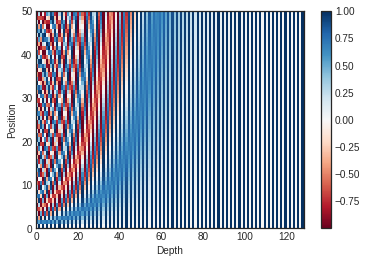

In [6]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap = 'RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 5.어텐션(Attention)

트랜스포머에서 사용되는 세 가지의 어텐션에 대해서 간단히 정리해보자. 지금은 큰 그림을 이해하는 것에만 집중한다.

<img src = 'https://wikidocs.net/images/page/31379/attention.PNG' width = 60%>

첫번째 그림인 셀프 어텐션은 인코더에서 이루어지지만, 두번째 그림인 셀프 어텐션과 세번째 그림인 인코더-디코더 어텐션은 디코더에서 이루어진다. 셀프 어텐션은 본질적으로 Query, key, Value가 동일한 경우를 말한다. 반면, 세번째 그림 인코더-디코더 어텐션에서는 Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터이므로 셀프 어텐션이라고 부르지 않는다.

* 주의할 점은 여기서 Query, Key 등이 같다는 것은 벡터의 값이 같다는 것이 아니라 벡터의 출처가 같다는 의미이다.

정리하면 다음과 같다.

* 인코더의 셀프 어텐션 : Query = Key = Value
* 디코더의 마스크드 셀프 어텐션 : Query = Key = Value
* 디코더의 인코더-디코더 어텐션 : Query : 디코더 벡터 / Key = Value : 인코더 벡터

<img src = 'https://wikidocs.net/images/page/31379/transformer_attention_overview.PNG' width = 60%>

위 그림은 트랜스포머의 아키텍처에서 세 가지 어텐션이 각각 어디에서 이루어지는지를 보여준다. 세 개의 어텐션에 추가적으로 '멀티 헤드'라는 이름이 붙어있다. 뒤에서 설명하겠지만, 이는 트랜스포머가 어텐션을 병렬적으로 수행하는 방법을 의미한다.



### 6.인코더(Encoder)

인코더의 구조에 대해서 알아보겠다.

<img src = 'https://wikidocs.net/images/page/31379/transformer9_final_ver.PNG' width = 60%>

트랜스포머는 하이퍼파라미터인 $\text{num_layers}$ 개수의 인코더 층을 쌓는다. 논문에서는 총 6개의 인코더 층을 사용하였다. 인코더를 하나의 층이라는 개념으로 생각한다면, 하나의 인코더 층은 크게 총 2개의 서브층(sublayer)으로 나뉘어진다. 바로 셀프 어텐션과 피드 포워드 신경망이다. 위의 그림에서는 멀티 헤드 셀프 어텐션과 포지션 와이즈 피드 포워드 신경망이라고 적혀있지만, 멀티 헤드 셀프 어텐션은 셀프 어텐션을 병렬적으로 사용하였다는 의미이고, 포지션 와이즈 피드 포워드 신경망은 우리가 알고있는 일반적인 피드 포워드 신경망이다. 우선 셀프 어텐션에 대해서 알아보자.



### 7.인코더의 셀프 어텐션

트랜스포머에서는 셀프 어텐션이라는 어텐션 기법이 등장하는데 앞서 배웠던 어텐션 함수에 대해서 복습하고, 셀프 어텐션이 앞서 배웠던 어텐션과 무엇이 다른지 이해해보겠다.



#### 1) 셀프 어텐션의 의미와 이점

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 가중치로 하여 키와 맵핑되어 있는 각각의 '값(Value)'에 반영해준다. 그리고 유사도가 반영된 '값(Value)'을 모두 가중합하여 리턴한다.

<img src = 'https://wikidocs.net/images/page/22893/%EC%BF%BC%EB%A6%AC.PNG' width = 60%>

여기까지는 앞서 배운 어텐션의 개념이다. 그런데 어텐션 중에서는 셀프 어텐션(self-attention)이라는 것이 있다. 단지 어텐션을 자기 자신에게 수행한다는 의미이다. 앞서 배운 seq2seq에서 어텐션을 사용할 경우의 Q, K, V의 정의를 다시 생각해보자.

* Q = Query : t 시점의 디코더 셀에서의 은닉 상태
* K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
* V = Values : 모든 시점의 인코더 셀의 은닉 상태들

그런데 사실 t 시점이라는 것은 계속 변화하면서 반복적으로 쿼리를 수행하므로 결국 전체 시점에 대해서 일반화를 할 수도 있다.

* Q = Querys : 모든 시점의 디코더 셀에서의 은닉 상태들
* K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
* V = Values : 모든 시점의 인코더 셀의 은닉 상태들

이처럼 기존에는 디코더 셀의 은닉 상태가 Q이고 인코더 셀의 은닉 상태가 K라는 점에서 Q와 K가 서로 다른 값을 가지고 있었다. 그런데 셀프 어텐션에서는 Q, K, V가 전부 동일하다. 트랜스포머의 셀프 어텐션에서의 Q, K, V는 아래와 같다.

* Q : 입력 문장의 모든 단어 벡터들
* K : 입력 문장의 모든 단어 벡터들
* V : 입력 문장의 모든 단어 벡터들

셀프 어텐션에 대한 구체적인 사항을 배우기 전에 셀프 어텐션을 통해 얻을 수 있는 대표적인 효과에 대해서 이해해보자.

<img src = 'https://wikidocs.net/images/page/31379/transformer10.png' width = 60%>

위의 그림은 트랜스포머에 대한 구글 AI 블로그 포스트에서 가져왔다. 위의 예시 문장을 번역하면 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.'라는 의미가 된다. 그런데 여기서 그것(it)에 해당하는 것은 과연 길(street)일까? 동물(animal)일까? 우리는 피곤한 주체가 동물이라는 것을 아주 쉽게 알 수 있지만 기계는 그렇지 않다. 하지만 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구함으로써 그것(it)이 동물(animal)과 연관되었을 확률이 높다는 것을 찾아낸다.

이제 트랜스포머에서의 셀프 어텐션의 동작 메커니즘을 알아보자.



#### 2) Q, K, V 벡터 얻기

앞서 셀프 어텐션은 입력 문장의 단어 벡터들을 가지고 수행한다고 하였는데, 사실 셀프 어텐션은 인코더의 초기 입력인 $d_{model}$의 차원을 가지는 단어 벡터들을 사용하여 셀프 어텐션을 수행하는 것이 아니라 우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거친다. 이때 이 Q벡터, K벡터, V벡터들은 초기 입력인 $d_{model}$의 차원을 가지는 단어 벡터들보다 더 작은 차원을 가지는데, 논문에서는 $d_{model}$ = 512의 차원을 가졌던 각 단어 벡터들을 64의 차원을 가지는 Q벡터, K벡터, V벡터로 변환하였다.

64라는 값은 트랜스포머의 또 다른 하이퍼파라미터인 $\text{num_heads}$로 인해 결정되는데, 트랜스포머는 $d_{model}$을 $\text{num_heads}$로 나눈 값을 Q벡터, K벡터, V벡터의 차원으로 결정한다. 논문에서는 $\text{num_heads}$를 8로 하였다. 이제 그림을 통해 이해해보자. 예를 들어 여기서 사용하고 있는 예문 중 student라는 단어 벡터를 Q, K, V의 벡터로 변환하는 과정을 보겠다.

<img src = 'https://wikidocs.net/images/page/31379/transformer11.PNG' width = 60%>

기존의 벡터로부터 더 작은 벡터는 가중치 행렬을 곱함으로써 완성된다. 각 가중치 행렬은 $d_{model} × (d_{model}\text{/num_heads})$의 크기를 가진다. 이 가중치 행렬은 훈련 과정에서 학습된다. 즉, 논문과 같이 $d_{model}$ = 512이고 $\text{num_heads}$ = 8이라면, 각 벡터에 대해 3개의 서로 다른 가중치 행렬을 곱하고 64의 크기를 가지는 Q, K, V 벡터를 얻어낸다. 위의 그림은 단어 벡터 중 student 벡터로부터 Q, K, V 벡터를 얻어내는 모습을 보여준다. 모든 단어 벡터에 위와 같은 과정을 거치면 I, am, a, student는 각각 Q, K, V 벡터를 얻는다.



#### 3) 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)

Q, K, V 벡터를 얻었다면 지금부터는 기존에 배운 어텐션 메커니즘과 동일하다. 각 Q 벡터는 모든 K 벡터에 대해서 어텐션 스코어를 구하고, 어텐션 분포를 구한 뒤에 이를 사용하여 모든 V 벡터를 가중합하여 어텐션 값 또는 컨텍스트 벡터를 구하게 된다. 그리고 이를 모든 Q 벡터에 대해서 반복한다.

그런데 앞서 어텐션 챕터에서 어텐션 함수의 종류는 다양하다고 언급한 바 있다. 트랜스포머에서는 어텐션 챕터에 사용했던 내적만을 사용하는 어텐션 함수 $score(q, k)=q⋅k$가 아니라 여기에 특정값으로 나눠준 어텐션 함수인 $score(q, k)=q⋅k/\sqrt{n}$를 사용한다. 이러한 함수를 사용하는 어텐션을 어텐션 챕터에서 배운 닷-프로덕트 어텐션(dot-product attention)에서 값을 스케일링하는 것을 추가하였다고 하여 **스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)**이라고 한다. 이제 그림을 통해 이해해보자.

<img src = 'https://wikidocs.net/images/page/31379/transformer13.PNG' width = 60%>

우선 단어 I에 대한 Q벡터를 기준으로 설명해보겠다. 지금부터 설명하는 과정은 am에 대한 Q벡터, a에 대한 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 거친다. 위의 그림은 단어 I에 대한 Q 벡터가 모든 K 벡터에 대해서 어텐션 스코어를 구하는 것을 보여준다. 위의 128과 32는 저자가 임의로 가정한 수치로 신경쓰지 않아도 좋다.

위의 그림에서 어텐션 스코어는 각각 단어 I가 단어 I, am, a, student와 얼마나 연관되어 있는지를 보여주는 수치이다. 트랜스포머에서는 두 벡터의 내적값을 스케일링하는 값으로 K 벡터의 차원을 나타내는 $d_{k}$에 루트를 씌운 $\sqrt{d_{k}}$를 사용하는 것을 택했다. 앞서 언급하였듯이 논문에서 $d_{k}$는 $d_{model}\text{/num_heads}$라는 식에 따라서 64의 값을 가지므로 $\sqrt{d_{k}}$는 8의 값을 가진다.

<img src = 'https://wikidocs.net/images/page/31379/transformer14_final.PNG' width = 60%>

이제 어텐션 스코어에 소프트맥스 함수를 사용하여 어텐션 분포(Attention Distribution)을 구하고, 각 V 벡터와 가중합하여 어텐션 값(Attention Value)을 구한다. 이를 단어 I에 대한 어텐션 값 또는 단어 I에 대한 컨텍스트 벡터(context vector)라고도 부른다. 이제 am에 대한 Q벡터, a에 대한 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 반복하여 각각에 대한 어텐션 값을 구한다. 그런데 한 가지 의문이 남는다. 굳이 이렇게 각 Q 벡터마다 일일이 따로 연산할 필요가 있을까?



#### 4) 행렬 연산으로 일괄 처리하기

사실 각 단어에 대한 Q, K, V 벡터를 구하고 스케일드 닷-프로덕트 어텐션을 수행하였던 위의 과정들은 벡터 연산이 아니라 행렬 연산을 사용하면 일괄 계산이 가능하다. 지금까지 벡터 연산으로 설명하였던 이유는 이해를 돕기 위한 과정이고, 실제로는 행렬 연산으로 구현된다.

위의 과정을 벡터가 아닌 행렬 연산으로 이해해보자. 우선, 각 단어 벡터마다 일일이 가중치 행렬을 곱하는 것이 아니라 문장 행렬에 가중치 행렬을 곱하여 Q 행렬, K 행렬, V 행렬을 구한다.

<img src = 'https://wikidocs.net/images/page/31379/transformer12.PNG' width = 60%>

이제 행렬 연산을 통해 어텐션 스코어는 어떻게 구할 수 있을까? 여기서 Q 행렬을 K 행렬을 전치한 행렬과 곱해준다고 해보자. 이렇게 되면 각각의 단어의 Q벡터와 K벡터의 내적이 각 행렬의 원소가 되는 행렬이 결과로 나온다.

<img src = 'https://wikidocs.net/images/page/31379/transformer15.PNG' width = 60%>

다시 말해 위의 그림의 결과 행렬의 값에 전체적으로 $\sqrt{d_{k}}$를 나누어주면 이는 각 행과 열이 어텐션 스코어값을 가지는 행렬이 된다. 예를 들어 I행과 student열의 값은 I의 Q벡터와 student의 K벡터의 어텐션 스코어와 동일한 행렬이 된다는 것이다. 즉, 어텐션 스코어 행렬이다. 어텐션 스코어 행렬을 구하였다면 남은 것은 어텐션 분포를 구하고, 이를 사용하여 모든 단어에 대한 어텐션 값을 구하는 일이다. 이는 간단하게 어텐션 스코어 행렬에 소프트맥스 함수를 사용하고, V 행렬을 곱하는 것으로 해결된다. 이렇게 되면 각 단어의 어텐션 값을 모두 가지는 어텐션 값 행렬이 결과로 나온다.

<img src = 'https://wikidocs.net/images/page/31379/transformer16.PNG' width = 60%>

위의 그림은 행렬 연산을 통해 모든 값이 일괄 계산되는 과정을 식으로 보여준다. 해당 식은 실제 트랜스포머 논문에 기재된 아래의 수식과 정확하게 일치하는 식이다.

$Attention(Q, K, V) = softmax({QK^T\over{\sqrt{d_k}}})V$

위의 행렬 연산에 사용된 행렬의 크기를 모두 정리해보자. 우선 입력 문장의 길이를 seq_len이라고 해보자. 그렇다면 문장 행렬의 크기는 $(\text{seq_len},\ d_{model})$이다. 여기에 3개의 가중치 행렬을 곱해서 Q, K, V 행렬을 만들어야 한다.

우선 행렬의 크기를 정의하기 위해 행렬의 각 행에 해당되는 Q 벡터와 K 벡터의 크기를 $d_{k}$라고 하고, V 벡터의 크기를 $d_{v}$라고 해보자. 그렇다면 Q 행렬과 K 행렬의 크기는 $(\text{seq_len},\ d_{k})$이며, V 행렬의 크기는 $(\text{seq_len},\ d_{v})$가 되어야 한다. 그렇다면 문장 행렬과 Q, K, V 행렬의 크기로부터 가중치 행렬의 크기 추정이 가능하다. $W^{Q}$와 $W^{K}$는 $(d_{model},\ d_{k})$의 크기를 가지며, $W^{V}$는 $(d_{model},\ d_{v})$의 크기를 가진다. 단, 논문에서는 $d_{k}$와 $d_{v}$의 크기는 $d_{model}\text{/num_heads}$와 같다. 즉, $d_{model}\text{/num_heads}= d_{k}=d_{v}$이다.

결과적으로 $softmax({QK^T\over{\sqrt{d_k}}})V$ 식을 적용하여 나오는 어텐션 값 행렬 $a$의 크기는 $(\text{seq_len},\ d_{v})$이 된다. 

코드로 작성하면 아래와 같다.


#### 5) 스케일드 닷-프로덕트 어텐션 구현하기



In [7]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b = True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis = -1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

코드는 위의 내용을 이해했다면 어렵지 않다. Q 행렬과 K 행렬을 전치한 행렬을 곱하고, 소프트맥스 함수를 사용하여 어텐션 분포 행렬을 얻은 뒤에 V 행렬과 곱한다. 코드에서 mask가 사용되는 if문은 아직 배우지 않은 내용으로 지금은 무시하고 넘어간다.

scaled_dot_product_attention 함수가 정상 작동하는지 테스트를 해보겠다. 우선 temp_q, temp_k, temp_v라는 임의의 Query, Key, Value 행렬을 만들고, 이를 scaled_dot_product_attention 함수에 입력으로 넣어 함수가 리턴하는 값을 출력해볼 것이다.



In [8]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress = True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype = tf.float32) # (4, 3)

temp_v = tf.constant([[   1, 0],
                      [  10, 0],
                      [ 100, 5],
                      [1000, 6]], dtype = tf.float32) # (4, 2)

temp_q = tf.constant([[0, 10, 0]], dtype = tf.float32) # (1, 3)

여기서 주목할 점은 Query에 해당하는 temp_q의 값 [0, 10, 0]은 Key에 해당하는 temp_k의 두번째 값 [0, 10, 0]과 일치한다는 점이다. 그렇다면 어텐션 분포와 어텐션 값은 과연 어떤 값이 나올까?


In [9]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


Query는 4개의 Key값 중 두번째 값과 일치하므로 어텐션 분포는 [0, 1, 0, 0]의 값을 가지며 결과적으로 Value의 두번째 값인 [10, 0]이 출력되는 것을 확인할 수 있다. 이번에는 Query의 값만 다른 값으로 바꿔보고 함수를 실행해보자. 이번에 사용할 Query값 [0, 0, 10]은 Key의 세번째 값과, 네번째 값 두 개의 값 모두와 일치하는 값이다.


In [10]:
temp_q = tf.constant([[0, 0, 10]], dtype = tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


Query의 값은 Key의 세번째 값과 네번째 값 두 개의 값과 모두 유사하다는 의미에서 어텐션 분포는 [0, 0, 0.5, 0.5]의 값을 가진다. 결과적으로 나오는 값 [550, 5.5]는 Value의 세번째 값 [100, 5]에 0.5를 곱한 값과 네번째 값 [1000, 6]에 0.5를 곱한 값의 원소별 합이다. 이번에는 하나가 아닌 3개의 Query의 값을 함수의 입력으로 사용해보겠다.


In [11]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype = tf.float32) # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out)  # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


#### 6) 멀티 헤드 어텐션(Multi-head Attention)

앞서 배운 어텐션에서는 $d_{model}$의 차원을 가진 단어 벡터를 $\text{num_heads}$로 나눈 차원을 가지는 Q, K, V벡터로 바꾸고 어텐션을 수행하였다. 논문 기준으로는 512의 차원의 각 단어 벡터를 8로 나눠 64차원의 Q, K, V 벡터로 바꾸어서 어텐션을 수행한 셈인데, 이제 $\text{num_heads}$의 의미와 왜 $d_{model}$의 차원을 가진 단어 벡터를 가지고 어텐션을 하지 않고 차원을 축소시킨 벡터로 어텐션을 수행하였는지 이해해보겠다.

<img src = 'https://wikidocs.net/images/page/31379/transformer17.PNG' width = 60%>

트랜스포머 연구진은 한 번의 어텐션을 하는 것보다 여러번의 어텐션을 병렬로 사용하는 것이 더 효과적이라고 판단하였다. 그래서 $d_{model}$의 차원을 $\text{num_heads}$개로 나누어 $d_{model}\text{/num_heads}$의 차원을 가지는 Q, K, V에 대해서 $\text{num_heads}$개의 병렬 어텐션을 수행한다. 논문에서는 하이퍼파라미터인 $\text{num_heads}$의 값을 8로 지정하였고, 8개의 병렬 어텐션이 이루어지게 된다. 다시 말해 위에서 설명한 어텐션이 8개로 병렬로 이루어지게 되는데, 이때 각각의 어텐션 값 행렬을 어텐션 헤드라고 부른다. 이때 가중치 행렬 $W^{Q}, W^{K}, W^{V}$의 값은 8개의 어텐션 헤드마다 전부 다르다.

병렬 어텐션으로 얻을 수 있는 효과는 무엇일까? 그리스로마 신화에는 머리가 여러 개인 괴물 히드라나 케로베로스가 나온다. 이 괴물들의 특징은 머리가 여러 개이기 때문에 여러 시점에서 상대방을 볼 수 있다는 것이다. 이렇게 되면 시각에서 놓치는 게 별로 없을 테니까 이런 괴물들에게 기습을 하는 것이 굉장히 힘들 것이다. 멀티 헤드 어텐션도 똑같다. 어텐션을 병렬로 수행하여 다른 시각으로 정보들을 수집하겠다는 것이다.

예를 들어보겠다. 앞서 사용한 예문 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.를 상기해보자. 단어 그것(it)이 쿼리였다고 해보자. 즉, it에 대한 Q벡터로부터 다른 단어와의 연관도를 구하였을 때 첫번째 어텐션 헤드는 '그것(it)'과 '동물(animal)'의 연관도를 높게 본다면, 두번째 어텐션 헤드는 '그것(it)'과 '피곤하였기 때문이다(tired)'의 연관도를 높게 볼 수 있다. 각 어텐션 헤드는 전부 다른 시각에서 보고 있기 때문이다.

<img src = 'https://wikidocs.net/images/page/31379/transformer18_final.PNG' width = 60%>

병렬 어텐션을 모두 수행하였다면 모든 어텐션 헤드를 연결(concatenate)한다. 모두 연결된 어텐션 헤드 행렬의 크기는 $(\text{seq_len},\ d_{model})$가 된다.

지금까지 그림에서는 책의 지면상의 한계로 4차원을 $d_{model}$ = 512로 표현하고, 2차원을 $d_{v}$ = 64로 표현해왔기 때문에 위의 그림의 행렬의 크기에 혼동이 있을 수 있으나 8개의 어텐션 헤드의 연결(concatenate) 과정의 이해를 위해 이번 행렬만 예외로 위와 같이 $d_{model}$의 크기를 $d_{v}$의 8배인 16차원으로 표현하였다. 아래의 그림에서는 다시 $d_{model}$를 4차원으로 표현한다.

<img src = 'https://wikidocs.net/images/page/31379/transformer19.PNG' width = 60%>

어텐션 헤드를 모두 연결한 행렬은 또 다른 가중치 행렬 $W^{o}$을 곱하게 되는데, 이렇게 나온 결과 행렬이 멀티-헤드 어텐션의 최종 결과물이다. 위의 그림은 어텐션 헤드를 모두 연결한 행렬이 가중치 행렬 $W^{o}$과 곱해지는 과정을 보여준다. 이때 결과물인 멀티-헤드 어텐션 행렬은 인코더의 입력이었던 문장 행렬의 $(\text{seq_len},\ d_{model})$ 크기와 동일하다.

다시 말해 인코더의 첫번째 서브층인 멀티-헤드 어텐션 단계를 끝마쳤을 때, 인코더의 입력으로 들어왔던 행렬의 크기가 아직 유지되고 있음을 기억해두자. 첫번째 서브층인 멀티-헤드 어텐션과 두번째 서브층인 포지션 와이즈 피드 포워드 신경망을 지나면서 인코더의 입력으로 들어올 때의 행렬의 크기는 계속 유지되어야 한다. 트랜스포머는 다수의 인코더를 쌓은 형태인데(논문에서는 인코더가 6개), 인코더에서의 입력의 크기가 출력에서도 동일 크기로 계속 유지되어야만 다음 인코더에서도 다시 입력이 될 수 있기 때문이다.



#### 7) 멀티 헤드 어텐션(Multi-head Attention) 구현하기

멀티 헤드 어텐션에서는 크게 두 종류의 가중치 행렬이 나왔다. 바로 Q, K, V 행렬을 만들기 위한 가중치 행렬인 WQ, WK, WV 행렬과 바로 어텐션 헤드들을 연결(concatenation) 후에 곱해주는 WO 행렬이다. 가중치 행렬을 곱하는 것을 구현상에서는 입력을 밀집층(Dense layer)를 지나게 함으로써 구현한다. 케라스 코드 상으로 지금까지 줄기차게 사용해왔던 Dense()에 해당된다.

``` python
Dense(units)
```

멀티 헤드 어텐션의 구현은 크게 다섯 가지 파트로 구성된다.

1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게 한다.
2. 지정된 헤드 수(num_heads)만큼 나눈다(split).
3. 스케일드 닷 프로덕트 어텐션.
4. 나눠졌던 헤드들을 연결(concatenation)한다.
5. WO에 해당하는 밀집층을 지나게 한다.

이론으로 설명할 때보다 심플하게 구성되었는데 결국 근본적으로 동일한 내용이다.



In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name = 'multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name = name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units = d_model)
        self.key_dense = tf.keras.layers.Dense(units = d_model)
        self.value_dense = tf.keras.layers.Dense(units = d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units = d_model)

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape = (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm = [0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs
        

멀티 헤드 어텐션 함수를 구현해보았다. 이제 딱 한 가지만 더 설명하고, 두번째 서브층에 대한 설명으로 넘어가보자.



#### 8) 패딩 마스크(Padding Mask)

아직 설명하지 않은 내용이 있다. 앞서 구현한 스케일드 닷 프로덕트 어텐션 함수 내부를 보면 mask라는 값을 인자로 받아서, 이 mask값에다가 -1e9라는 아주 작은 음수값을 곱한 후 어텐션 스코어 행렬에 더해주고 있다. 이 연산의 정체는 무엇일까?

``` python
def scaled_dot_product_attention(query, key, value, mask):
... 중략 ...
    logits += (mask * -1e9) # 어텐션 스코어 행렬인 logits에 mask*-1e9 값을 더해주고 있다.
... 중략 ...
```

이는 입력 문장에 <(PAD)> 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산이다. 예를 들어 <(PAD)>가 포함된 입력 문장의 셀프 어텐션의 예제를 보자. 이에 대해서 어텐션을 수행하고 어텐션 스코어 행렬을 얻는 과정은 다음과 같다.

<img src = 'https://wikidocs.net/images/page/31379/pad_masking11.PNG' width = 60%>

그런데 사실 단어 <(PAD)>의 경우에는 실질적인 의미를 가진 단어가 아니다. 그래서 트랜스포머에서는 Key의 경우에 <(PAD)> 토큰이 존재한다면 이에 대해서는 유사도를 구하지 않도록 마스킹(Masking)을 해주기로 했다. 여기서 마스킹이란 어텐션에서 제외하기 위해 값을 가린다는 의미이다. 어텐션 스코어 행렬에서 행에 해당하는 문장은 Query이고, 열에 해당하는 문장은 Key이다. 그리고 Key에 <(PAD)>가 있는 경우에는 해당 열 전체를 마스킹을 해준다.

<img src = 'https://wikidocs.net/images/page/31379/pad_masking2.PNG' width = 60%>

마스킹을 하는 방법은 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수값을 넣어주는 것이다. 현재 어텐션 스코어 함수는 소프트맥스 함수를 지나지 않은 상태이다. 앞서 배운 연산 순서라면 어텐션 스코어 함수는 소프트맥스 함수를 지나고, 그 후 Value 행렬과 곱해지게 된다. 그런데 현재 마스킹 위치에 매우 작은 음수 값이 들어가 있으므로 어텐션 스코어 행렬이 소프트맥스 함수를 지난 후에는 해당 위치의 값은 0에 굉장히 가까운 값이 되어 단어 간 유사도를 구하는 일에 <(PAD)> 토큰이 반영되지 않게 된다.

<img src = 'https://wikidocs.net/images/page/31379/softmax.PNG' width = 60%>

위 그림은 소프트맥스 함수를 지난 후를 가정하고 있다. 소프트맥스 함수를 지나면 각 행의 어텐션 가중치의 총 합은 1이 되는데, 단어 <(PAD)>의 경우에는 0이 되어 어떤 유의미한 값을 가지고 있지 않다.

패딩 마스크를 구현하는 방법은 입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것이다. 아래의 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수이다.



In [15]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

임의의 정수 시퀀스 입력을 넣어서 어떻게 변환되는지 보겠다.

In [16]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


위 벡터를 통해서 1의 값을 가진 위치의 열을 어텐션 스코어 행렬에서 마스킹하는 용도로 사용할 수 있다. 위 벡터를 스케일드 닷 프로덕트 어텐션의 인자로 전달하면, 스케일드 닷 프로덕트 어텐션에서는 위 벡터에다가 매우 작은 음수값인 -1e9를 곱하고, 이를 행렬에 더해주어 해당 열을 전부 마스킹하게 되는 것이다.

첫번째 서브층인 멀티 헤드 어텐션을 구현해보았다. 앞서 인코더는 두 개의 서브층(sublayer)으로 나뉘어진다고 언급한 적이 있는데, 이제 두번째 서브층인 포지션-와이즈 피드 포워드 신경망에 대해서 알아보겠다.


### 8.포지션-와이즈 피드 포워드 신경망(Position-wise FFNN)

지금은 인코더를 설명하고 있지만, 포지션 와이즈 FFNN은 인코더와 디코더에서 공통적으로 가지고 있는 서브층이다. 포지션-와이즈 FFNN는 쉽게 말하면 완전 연결 FFNN(Fully-connected FFNN)이라고 해석할 수 있다. 앞서 인공 신경망은 결국 벡터와 행렬 연산으로 표현될 수 있음을 배웠다. 아래는 포지션 와이즈 FFNN의 수식을 보여준다.

$FFNN(x) = MAX(0, x{W_{1}} + b_{1}){W_2} + b_2$

식을 그림으로 표현하면 아래와 같다.

<img src = 'https://wikidocs.net/images/page/31379/positionwiseffnn.PNG' width = 60%>

여기서 $x$는 앞서 멀티 헤드 어텐션의 결과로 나온 $(\text{seq_len},\ d_{model})$의 크기를 가지는 행렬을 말한다. 가중치 행렬 $W_{1}$은 $(d_{model},\ d_{ff})$의 크기를 가지고, 가중치 행렬 $W_{2}$는 $(d_{ff},\ d_{model})$의 크기를 가진다. 논문에서 은닉층의 크기인 $d_{ff}$는 앞서 하이퍼파라미터를 정의할 때 언급했듯이 2,048의 크기를 가진다.

여기서 매개변수 $W_{1}, b_{1}, W_{2}, b_{2}$는 하나의 인코더 층 내에서는 다른 문장, 다른 단어들마다 정확하게 동일하게 사용된다. 하지만 인코더 층마다는 다른 값을 가진다.

<img src = 'https://wikidocs.net/images/page/31379/transformer20.PNG' width = 60%>

위의 그림에서 좌측은 인코더의 입력을 벡터 단위로 보았을 때, 각 벡터들이 멀티 헤드 어텐션 층이라는 인코더 내 첫번째 서브 층을 지나 FFNN을 통과하는 것을 보여준다. 이는 두번째 서브층인 Position-wise FFNN을 의미한다. 물론, 실제로는 그림의 우측과 같이 행렬로 연산되는데, 두번째 서브층을 지난 인코더의 최종 출력은 여전히 인코더의 입력의 크기였던 $(\text{seq_len},\ d_{model})$의 크기가 보존되고 있다. 하나의 인코더 층을 지난 이 행렬은 다음 인코더 층으로 전달되고, 다음 층에서도 동일한 인코더 연산이 반복된다.

이를 구현하면 다음과 같다.

``` python
# 다음의 코드는 인코더와 디코더 내부에서 사용할 예정이다.
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
```





### 9.잔차 연결(Residual connection)과 층 정규화(Layer Normalization)

<img src = 'https://wikidocs.net/images/page/31379/transformer21.PNG' width = 60%>

인코더의 두 개의 서브층에 대해서 이해했다면 인코더에 대한 설명은 거의 다 왔다. 트랜스포머에서는 이러한 두 개의 서브층을 가진 인코더에 추가적으로 사용하는 기법이 있는데, 바로 Add & Norm이다. 더 정확히는 잔차 연결(Residual connection)과 층 정규화(Layer normalization)를 의미한다.

위의 그림은 앞서 Position-wise FFNN을 설명할 때 사용한 앞선 그림에서 화살표와 Add & Norm(잔차 연결과 정규화 과정)을 추가한 그림이다. 추가된 화살표들은 서브층 이전의 입력에서 시작되어 서브층의 출력 부분을 향하고 있는 것에 주목하자. 추가된 화살표가 어떤 의미를 갖고 있는지는 잔차 연결과 층 정규화를 배우고 나면 이해할 수 있다.



#### 1) 잔차 연결(Residual connection)

잔차 연결(residual connection)의 의미를 이해하기 위해서 어떤 함수 $H(x)$에 대한 이야기를 해보겠다.

<img src = 'https://wikidocs.net/images/page/31379/transformer22.PNG' width = 60%>

위 그림은 입력 $x$와 $x$에 대한 어떤 함수 $F(x)$의 값을 더한 함수 $H(x)$의 구조를 보여준다. 어떤 함수 $F(x)$가 트랜스포머에서는 서브층에 해당된다. 다시 말해 잔차 연결은 서브층의 입력과 출력을 더하는 것을 말한다. 앞서 언급했듯이 트랜스포머에서 서브층의 입력과 출력은 동일한 차원을 갖고 있으므로, 서브층의 입력과 서브층의 출력은 덧셈 연산을 할 수 있다. 이것이 바로 위의 인코더 그림에서 각 화살표가 서브층의 입력에서 출력으로 향하도록 그려졌던 이유이다. 잔차 연결은 컴퓨터 비전 분야에서 주로 사용되는 모델의 학습을 돕는 기법이다.

이를 식으로 표현하면 $x+Sublayer(x)$라고 할 수 있다.

가령, 서브층이 멀티 헤드 어텐션이었다면 잔차 연결 연산은 다음과 같다.

$H(x) = x+Multi-head\ Attention(x)$

<img src = 'https://wikidocs.net/images/page/31379/residual_connection.PNG' width = 60%>

위 그림은 멀티 헤드 어텐션의 입력과 멀티 헤드 어텐션의 결과가 더해지는 과정을 보여준다.

관련 논문 : https://arxiv.org/pdf/1512.03385.pdf



#### 2) 층 정규화(Layer Normalization)

잔차 연결을 거친 결과는 이어서 층 정규화 과정을 거치게 된다. 잔차 연결의 입력을 $x$, 잔차 연결과 층 정규화 두 가지 연산을 모두 수행한 후의 결과 행렬을 $LN$이라고 하였을 때, 잔차 연결 후 층 정규화 연산을 수식으로 표현하자면 다음과 같다.

$LN = LayerNorm(x+Sublayer(x))$

이제 층 정규화를 하는 과정에 대해서 이해해보자. 층 정규화는 **텐서의 마지막 차원**에 대해서 평균과 분산을 구하고, 이를 가지고 어떤 수식을 통해 값을 정규화하여 학습을 돕는다. 여기서 텐서의 마지막 차원이라는 것은 트랜스포머에서 $d_{model}$ 차원을 의미한다. 아래 그림은 $d_{model}$ 차원의 방향을 화살표로 표현하였다.

<img src = 'https://wikidocs.net/images/page/31379/layer_norm_new_1_final.PNG' width = 60%>

층 정규화를 위해서 우선, 화살표 방향으로 각각 평균 $μ$와 분산 $σ^{2}$을 구한다. 각 화살표 방향의 벡터를 $x_{i}$라고 명명해보자.

<img src = 'https://wikidocs.net/images/page/31379/layer_norm_new_2_final.PNG' width = 60%>

층 정규화를 수행한 후에는 벡터 $x_{i}$는 $ln_{i}$ 라는 벡터로 정규화가 된다.

$ln_{i} = LayerNorm(x_{i})$

이제 층 정규화의 수식을 알아보자. 여기서는 층 정규화를 두 가지 과정으로 나누어서 설명하겠다. 첫번째는 평균과 분산을 통한 정규화, 두번째는 감마와 베타를 도입하는 것이다. 우선, 평균과 분산을 통해 벡터 $x_{i}$를 정규화 해준다. $x_{i}$는 벡터인 반면, 평균 $μ_{i}$와 분산 $σ^{2}_{i}$은 스칼라이다. 벡터 $x_{i}$의 각 차원을 $k$라고 하였을 때, $x_{i,k}$는 다음의 수식과 같이 정규화 할 수 있다. 다시 말해 벡터 $x_{i}$의 각 $k$차원의 값이 다음과 같이 정규화되는 것이다.

$\hat{x}_{i, k} = \frac{x_{i, k}-μ_{i}}{\sqrt{σ^{2}_{i}+\epsilon}}$

$ϵ$(입실론)은 분모가 0이 되는 것을 방지하는 값이다.

이제 $γ$(감마)와 $β$(베타)라는 벡터를 준비한다. 단, 이들의 초기값은 각각 1과 0이다.

<img src = 'https://wikidocs.net/images/page/31379/%EA%B0%90%EB%A7%88%EB%B2%A0%ED%83%80.PNG' width = 60%>

$γ$와 $β$를 도입한 층 정규화의 최종 수식은 다음과 같으며, $γ$와 $β$는 학습 가능한 파라미터이다.

$ln_{i} = γ\hat{x}_{i}+β = LayerNorm(x_{i})$

관련 논문 : https://arxiv.org/pdf/1607.06450.pdf

케라스에서는 LayerNormalization()를 이미 제공하고 있으므로, 이를 가져와 사용한다.



### 10.인코더 구현하기

지금까지 배운 내용을 바탕으로 인코더를 구현한 코드는 다음과 같다.


In [21]:
def encoder_layer(dff, d_model, num_heads, dropout, name = 'encoder_layer'):
    inputs = tf.keras.Input(shape = (None, d_model), name = 'inputs')

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = 'padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name = 'attention')(
        {'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
         'mask': padding_mask # 패딩 마스크 사용
        })
    
    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate = dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units = dff, activation = 'relu')(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs = [inputs, padding_mask], outputs = outputs, name = name)
    

우선 인코더의 입력으로 들어가는 문장에는 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용한다. 이는 MultiHeadAttention 함수의 mask의 인자값으로 padding_mask가 들어가는 이유이다. 인코더는 총 두 개의 서브층으로 이루어지는데, 멀티 헤드 어텐션과 피드 포워드 신경망이다. 각 서브층 이후에는 드롭 아웃, 잔차 연결과 층 정규화가 수행된다.

위 코드는 하나의 인코더 블록. 즉, 하나의 인코더 층을 구현하는 코드이다. 물론, 실제로 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 별도 구현해줄 필요가 있다.


### 11.인코더 쌓기

지금까지 인코더 층의 내부 아키텍처에 대해서 이해해보았다. 이러한 인코더 층을 num_layers개만큼 쌓고, 마지막 인코더 층에서 얻는 (seq_len, d_model) 크기의 행렬을 디코더로 보내줌으로써 트랜스포머 인코더의 인코딩 연산이 끝나게 된다. 아래의 코드는 인코더 층을ㄹ num_layers개만큼 쌓는 코드이다.


In [22]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name = 'encoder'):
    inputs = tf.keras.Input(shape = (None, ), name = 'inputs')

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = 'padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff = dff, d_model = d_model,
                                num_heads = num_heads, dropout = dropout,
                                name = 'encoder_layer_{}'.format(i))([outputs, padding_mask])
    return tf.keras.Model(inputs = [inputs, padding_mask],
                          outputs = outputs, 
                          name = name)
    

### 12.인코더에서 디코더로(From Encoder To Decoder)

<img src = 'https://wikidocs.net/images/page/31379/transformer_from_encoder_to_decoder.PNG' width = 60%>

지금까지 인코더에 대해서 정리해보았다. 이렇게 구현된 인코더는 총 $\text{num_layers}$만큼의 층 연산을 순차적으로 한 후에 마지막 층의 인코더의 출력을 디코더에게 전달한다. 인코더 연산이 끝났으므로 이제 디코더 연산이 시작되어 디코더 또한 총 $\text{num_layers}$만큼의 연산을 하는데, 이때마다 인코더가 보낸 출력을 각 디코더 층 연산에 사용한다. 이제 본격적으로 **디코더**에 대해서 이해해보자.



### 13.디코더의 첫번째 서브층 : 셀프 어텐션과 룩-어헤드 마스크

<img src = 'https://wikidocs.net/images/page/31379/decoder.PNG' width = 60%>

위 그림과 같이 디코더도 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력된다. 트랜스포머 또한 seq2seq와 마찬가지로 교사 강요(Teacher Forcing)을 사용하여 훈련되므로 학습 과정에서 디코더는 번역할 문장에 해당되는 <(sos)> je suis étudiant의 문장 행렬을 한 번에 입력받는다. 그리고 디코더는 이 문장 행렬로부터 각 시점의 단어를 예측하도록 훈련된다.

여기서 문제가 있다. seq2seq의 디코더에 사용되는 RNN 계열의 신경망은 입력 단어를 매 시점마다 순차적으로 받으므로 다음 단어 예측에 현재 시점 이전에 입력된 단어들만 참고할 수 있다. 반면, 트랜스포머는 문장 행렬로 입력을 한 번에 받으므로 현재 시점의 단어를 예측하고자 할 때, 입력 문장 행렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상이 발생한다. 가령, suis를 예측해야 하는 시점이라고 해보자. seq2seq의 디코더라면 현재까지 디코더에 입력된 단어는 <(sos)>와 je뿐일 것이다. 반면, 트랜스포머는 이미 문장 행렬로 <(sos)> je suis étudiant를 입력받았다.

이를 위해 트랜스포머의 디코더에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 룩-어헤드 마스크(look-ahead mask)를 도입했다. 직역하면 '미리보기에 대한 마스크'라고 할 수 있다.

<img src = 'https://wikidocs.net/images/page/31379/%EB%94%94%EC%BD%94%EB%8D%94.PNG' width = 60%>

룩-어헤드 마스크(look-ahead mask)는 디코더의 첫번째 서브층에서 이루어진다. 디코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층은 인코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층과 동일한 연산을 수행한다. 오직, 다른 점은 어텐션 스코어 행렬에서 마스킹을 적용한다는 점만 다르다. 우선, 다음과 같이 셀프 어텐션을 통해 어텐션 스코어 행렬을 얻는다.

<img src = 'https://wikidocs.net/images/page/31379/decoder_attention_score_matrix.PNG' width = 60%>

이제 자기 자신보다 미래에 있는 단어들은 참고하지 못하도록 다음과 같이 마스킹한다.

<img src = 'https://wikidocs.net/images/page/31379/%EB%A3%A9%EC%96%B4%ED%97%A4%EB%93%9C%EB%A7%88%EC%8A%A4%ED%81%AC.PNG' width = 60%>

마스킹된 후의 어텐션 스코어 행렬의 각 행을 보면 자기 자신과 그 이전 단어들만을 참고할 수 있음을 볼 수 있다. 그 외에는 근본적으로 셀프 어텐션이라는 점과, 멀티 헤드 어텐션을 수행한다는 점에서 인코더의 첫번째 서브층과 같다.

룩-어헤드 마스크 구현에 대해 알아보자. 룩-어헤드 마스크는 패딩 마스크와 마찬가지로 앞서 구현한 스케일드 닷 프로덕트 어텐션 함수에 mask라는 인자로 전달된다. 패딩 마스킹을 써야하는 경우에는 스케일드 닷 프로덕트 어텐션 함수에 패딩 마스크를 전달하고, 룩-어헤드 마스킹을 써야하는 경우에는 스케일드 닷 프로덕트 어텐션 함수에 룩-어헤드 마스크를 전달하게 된다.

``` python
# 스케일드 닷 프로덕트 어텐션 함수를 다시 복습해보자.
def scaled_dot_product_attention(query, key, value, mask):
... 중략 ...
    logits += (mask * -1e9) # 어텐션 스코어 행렬인 logits에 mask*-1e9 값을 더해주고 있다.
... 중략 ...
```

트랜스포머에는 총 세 가지 어텐션이 존재하며, 모두 멀티 헤드 어텐션을 수행하고, 멀티 헤드 어텐션 함수 내부에서 스케일드 닷 프로덕트 어텐션 함수를 호출하는데 각 어텐션 시 함수에 전달하는 마스킹은 다음과 같다.

* 인코더의 셀프 어텐션 : 패딩 마스크를 전달
* 디코더의 첫번째 서브층인 마스크드 셀프 어텐션 : 룩-어헤드 마스크를 전달 <-- 지금 배우고 있음.
* 디코더의 두번째 서브층인 인코더-디코더 어텐션 : 패딩 마스크를 전달

이때, 룩-어헤드 마스크를 한다고해서 패딩 마스크가 불필요한 것이 아니므로 룩-어헤드 마스크는 패딩 마스크를 포함하도록 구현한다. 룩-어헤드 마스크를 구현하는 방법은 패딩 마스크 때와 마찬가지로 마스킹을 하고자 하는 위치에는 1을, 마스킹을 하지 않는 위치에는 0을 리턴하도록 한다.




In [23]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)
    

임의의 정수 시퀀스 입력을 넣어서 결과를 보자. 패딩 마스크를 테스트하기 위해 세번째 위치에 정수 0을 넣었다.


In [24]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


룩-어헤드 마스크이므로 삼각형 모양의 마스킹이 형성되면서, 패딩 마스크가 포함되어져 있으므로 세번째 열이 마스킹되었다.


### 14.디코더의 두번째 서브층 : 인코더-디코더 어텐션

디코더의 두번째 서브층에 대해서 이해해보자. 디코더의 두번째 서브층은 멀티 헤드 어텐션을 수행한다는 점에서는 이전의 어텐션들(인코더와 디코더의 첫번째 서브층)과 같지만, 셀프 어텐션은 아니다.

셀프 어텐션은 Query, Key, Value가 같은 경우를 말하는데, 인코더-디코더 어텐션은 Query가 디코더인 행렬인 반면, Key와 Value는 인코더 행렬이기 때문이다. 다시 한 번 각 서브층에서의 Q, K, V의 관계를 정리해보자.

* 인코더의 첫번째 서브층 : Query = Key = Value
* 디코더의 첫번째 서브층 : Query = Key = Value
* 디코더의 두번째 서브층 : Query : 디코더 행렬 / Key = Value : 인코더 행렬

디코더의 두번째 서브층을 확대해보면, 다음과 같이 인코더로부터 두 개의 화살표가 그려져 있다.

<img src = 'https://wikidocs.net/images/page/31379/%EB%94%94%EC%BD%94%EB%8D%94%EB%91%90%EB%B2%88%EC%A7%B8%EC%84%9C%EB%B8%8C%EC%B8%B5.PNG' width = 60%>

두 개의 화살표는 각각 Key와 Value를 의미하며, 이는 인코더의 마지막 층에서 온 행렬로부터 얻는다. 반면, Query는 디코더의 첫번째 서브층의 결과 행렬로부터 얻는다는 점이 다르다. Query가 디코더 행렬, Key가 인코더 행렬일 때, 어텐션 스코어 행렬을 구하는 과정은 다음과 같다.

<img src = 'https://wikidocs.net/images/page/31379/%EB%94%94%EC%BD%94%EB%8D%94%EB%91%90%EB%B2%88%EC%A7%B8%EC%84%9C%EB%B8%8C%EC%B8%B5%EC%9D%98%EC%96%B4%ED%85%90%EC%85%98%EC%8A%A4%EC%BD%94%EC%96%B4%ED%96%89%EB%A0%AC_final.PNG' width = 60%>

그 외에 멀티 헤드 어텐션을 수행하는 과정은 다른 어텐션들과 같다.



### 15.디코더 구현하기


In [25]:
def decoder_layer(dff, d_model, num_heads, dropout, name = 'decoder_layer'):
    inputs = tf.keras.Input(shape = (None, d_model), name = 'inputs')
    enc_outputs = tf.keras.Input(shape = (None, d_model), name = 'encoder_outputs')

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape = (1, None, None), name = 'look_ahead_mask')

    # 패딩 마스크(두번째 서브층)
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = 'padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name = 'attention_1')(inputs = {
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': look_ahead_mask # 룩어헤드 마스크
        })
    
    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon = 1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name = 'attention_2')(inputs = {
            'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
            'mask': padding_mask # 패딩 마스크
        })
    
    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate = dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon = 1e-6)(attention2 + attention1)
    
    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units = dff, activation = 'relu')(attention2)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon = 1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs = outputs,
        name = name)
    

디코더는 총 세 개의 서브층으로 구성된다. 첫번째와 두번째 서브층 모두 멀티 헤드 어텐션이지만, 첫번째 서브층은 mask의 인자값으로 look_ahead_mask가 들어가는 반면, 두번째 서브층은 mask의 인자값으로 padding_mask가 들어가는 것을 확인할 수 있다. 이는 첫번째 서브층은 마스크드 셀프 어텐션을 수행하기 때문이다. 세 개의 서브층 모두 서브층 연산 후에는 드롭 아웃, 잔차 연결, 층 정규화가 수행되는 것을 확인할 수 있다.

인코더와 마찬가지로 디코더도 num_layers개만큼 쌓는 코드가 필요하다. 아래를 보겠다.


### 16.디코더 쌓기


In [26]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name = 'decoder'):
    inputs = tf.keras.Input(shape = (None, ), name = 'inputs')
    enc_outputs = tf.keras.Input(shape = (None, d_model), name = 'encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
        shape = (1, None, None), name = 'look_ahead_mask')
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = 'padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff = dff, d_model = d_model, 
                                num_heads = num_heads, dropout = dropout,
                                name = 'decoder_layer_{}'.format(i))(
                                    inputs = [outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(
        inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs = outputs,
        name = name)
    

### 17.트랜스포머 구현하기

이제 지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립할 차례이다. 인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달해준다. 그리고 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 신경망을 추가해준다.


In [27]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout,
                name = 'transformer'):
    # 인코더의 입력
    inputs = tf.keras.Input(shape = (None, ), name = 'inputs')

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape = (None, ), name = 'dec_inputs')

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape = (1, 1, None),
        name = 'enc_padding_mask')(inputs)
    
    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape = (1, None, None),
        name = 'look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape = (1, 1, None),
        name = 'dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size = vocab_size,
                          num_layers = num_layers, dff = dff, d_model = d_model,
                          num_heads = num_heads, dropout = dropout)(inputs = [inputs, enc_padding_mask]) 
                          # 인코더의 입력은 입력 문장과 패딩 마스크
    
    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size = vocab_size, num_layers = num_layers,
                          dff = dff, d_model = d_model, num_heads = num_heads, 
                          dropout = dropout)(inputs = [dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units = vocab_size, name = 'outputs')(dec_outputs)                      

    return tf.keras.Model(inputs = [inputs, dec_inputs],
                          outputs = outputs, name = name)
    

### 18.트랜스포머 하이퍼파라미터 정하기

이제 트랜스포머의 하이퍼파라미터를 임의로 정하고, 모델을 만들어보자. 현재 훈련 데이터가 존재하는 것은 아니지만, 단어 집합의 크기는 임의로 9,000으로 정한다. 단어 집합의 크기로부터 룩업 테이블을 수행할 임베딩 테이블과 포지셔널 인코딩 행렬의 행의 크기를 결정할 수 있다.

여기서는 논문에서 제시한 것과는 조금 다르게 하이퍼파라미터를 정해보겠다. 인코더와 디코더의 층의 개수 $\text{num_layers}$는 4개, 인코더와 디코더의 포지션 와이즈 피드 포워드 신경망의 은닉층 $d_{ff}$은 128, 인코더와 디코더의 입, 출력의 차원 $d_{model}$은 128, 멀티-헤드 어텐션에서 병렬적으로 사용할 헤드의 수 $\text{num_heads}$는 4로 정했다. 이렇게 되면 128/4의 값인 32가 $d_{v}$의 값이 되겠다.



(1, 9000, 128)
(1, 9000, 128)


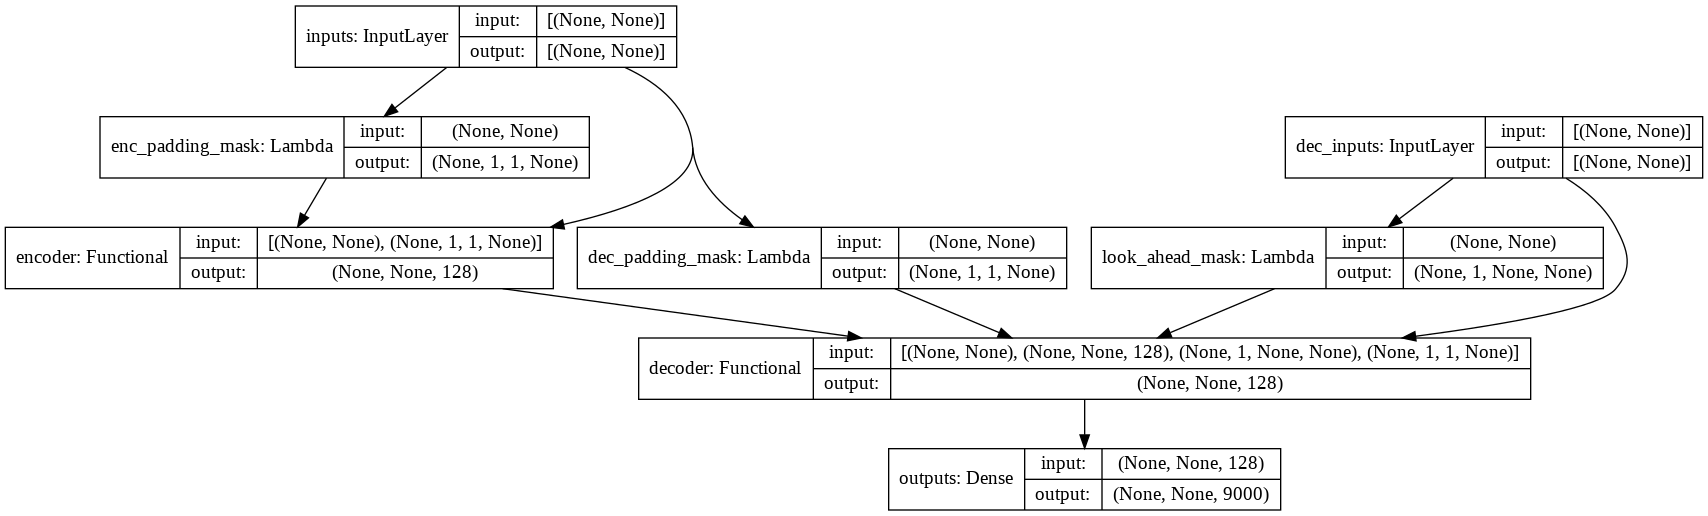

In [29]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name = 'small_transformer')

tf.keras.utils.plot_model(
    small_transformer, to_file = 'small_transformer.png', show_shapes = True)


### 19.손실 함수 정의하기

다중 클래스 분류 문제를 풀 예정이므로 크로스 엔트로피 함수를 손실 함수로 정의한다.


In [30]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape = (-1, MAX_LENGTH -1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits = True, reduction = 'none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf_float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 20.학습률

트랜스포머의 경우 학습률(learning rate)은 고정된 값을 유지하는 것이 아니라, 학습 경과에 따라 변하도록 설계하였다. 아래의 공식으로 학습률을 계산하여 사용하였으며, warmup_steps의 값으로는 4,000을 사용하였다.

$\Large{lrate = d_{model}^{-0.5} × min(\text{step_num}^{-0.5},\ \text{step_num} × \text{warmup_steps}^{-1.5})}$



In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        

Text(0.5, 0, 'Train Step')

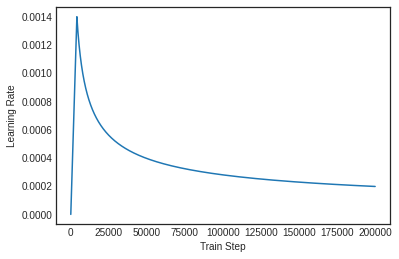

In [32]:
sample_learning_rate = CustomSchedule(d_model = 128)

plt.plot(sample_learning_rate(tf.range(200000, dtype = tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

이제 여기서 구현한 트랜스포머 모델을 바탕으로 다음 챕터에서 이어서 챗봇을 만들어보겠다.


논문에서는 언급되지 않은 트랜스포머의 구현 이야기 :

https://tunz.kr/post/4
